In [1]:
from composer.utils.object_store import ObjectStoreProviderHparams
from lth_diet.exps import LotteryExperiment
from lth_diet.utils import utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from tqdm import tqdm
plt.style.use("default")
rc = {"figure.figsize": (4, 3), "figure.dpi": 150, "figure.constrained_layout.use": True, "axes.grid": True, 
      "axes.spines.right": False, "axes.spines.top": False, "axes.linewidth": 0.6, "grid.linewidth": 0.6,
      "xtick.major.width": 0.6, "ytick.major.width": 0.6, "xtick.major.size": 4, "ytick.major.size": 4, 
      "axes.labelsize": 11, "axes.titlesize": 11, "xtick.labelsize": 10, "ytick.labelsize": 10,
      "axes.titlepad": 4, "axes.labelpad": 2, "xtick.major.pad": 2, "ytick.major.pad": 2,
      "lines.linewidth": 1.2, 'lines.markeredgecolor': 'w', "patch.linewidth": 0}
sns.set_theme(style='ticks', palette=sns.color_palette("tab10"), rc=rc)
object_store = ObjectStoreProviderHparams('google_storage', 'prunes', 'GCS_KEY').initialize_object()
bucket_dir = os.environ['OBJECT_STORE_DIR']

In [2]:
def get_accuracy_val(exp, reps, object_store, level):
    exp_hash = utils.get_hash(exp.name)
    steps_rt, accs_rt = [], []
    for rep in reps:
        object_store.download_object(
            f"{bucket_dir}/{exp_hash}/replicate_{rep}/level_{level}/main/log.txt", "temp.txt"
        )
        log = pd.read_table("temp.txt", header=None)[0]
        os.remove("temp.txt")
        steps_t, accs_t = [], []
        for line in log:
            match = re.search('\[EPOCH\]\[step=(\d*)\]: { "accuracy/val": ([+-]?[0-9]*[.]?[0-9]+), \}', line)
            if match:
                steps_t.append(int(match.group(1)))
                accs_t.append(float(match.group(2)))
        steps_rt.append(steps_t)
        accs_rt.append(accs_t)
    steps_rt, accs_rt = np.array(steps_rt), np.array(accs_rt)
    return steps_rt, accs_rt

In [4]:
config = f"../configs/lottery_test.yaml"
reps = [0, 1]
rewinding_steps = [58500, 54600, 50700, 46800, 42900, 39000, 35100]
num_levels = 15
exp = LotteryExperiment.create(f=config, cli_args=False)
accs_slr = []
for s in tqdm(rewinding_steps):
    accs_lr = []
    for l in range(num_levels+1):
        exp.rewinding_steps = f"{s}ba"
        _, accs_rt = get_accuracy_val(exp, reps, object_store, l)
        accs_lr.append(accs_rt[:, -1])
    accs_slr.append(accs_lr)
accs_slr = np.array(accs_slr)

100%|██████████| 7/7 [02:13<00:00, 19.11s/it]


Text(0.5, 1.0, 'CIFAR10 ResNet20')

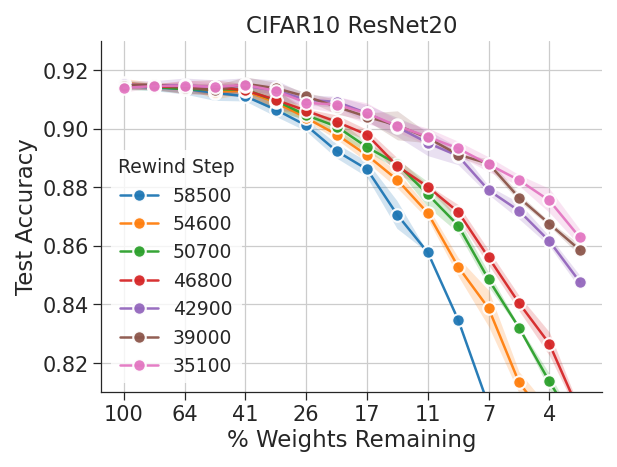

In [10]:
fig, axes = plt.subplots(dpi=150)
ls = []
ax = axes
for i in range(len(rewinding_steps)):
    x, ys = np.array(range(num_levels+1)), accs_slr[i]
    ym, ye = ys.mean(-1), ys.std(-1)
    ax.plot(x, ym, marker='o', alpha=0.95, label=rewinding_steps[i])
    ax.fill_between(x, ym-ye, ym+ye, alpha=0.2)
ax.legend(fontsize=9, title="Rewind Step", title_fontsize=9)
ax.set_ylim(0.81, 0.93)
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14], ['100', '64', '41', '26', '17', '11', '7', '4'])
ax.set_ylabel("Test Accuracy")
ax.set_xlabel("% Weights Remaining")
ax.set_title("CIFAR10 ResNet20")